# Students and Alcohol Consumption

### Context
[Kaggle’s Student Alcohol Consumption survey](https://www.kaggle.com/uciml/student-alcohol-consumption#student-por.csv) was conducted among students at Gabriel Pereira and Mousinho da Silveira secondary school in Porto, Portugal. Students in math and Portuguese language courses were selected to participate in the data collection. The survery contains various social, gender, and study information about students in regards to predicting their final grade.

Since this dataset consists of two parts, math and Portuguese language courses, we will merge together the files and examine it as one set. There are 382 students that belong to both datasets so we will join the files without overlapping data points. We will also assume that this dataset is a representative sample of the entire student population among the schools. Although each student's response can be viewed independently from another response, several datapoints maybe dependent on each other. For example, travel time to school will be dependent of the student's address. 


In [1]:
# Libraries

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline


In [2]:
# Load and merge math and Portuguese language course files 

d1 = pd.read_csv('student-mat.csv')
d2 = pd.read_csv("student-por.csv")

data = pd.merge(d1, d2, how='outer', on=["school","sex","age","address","famsize",
                                         "Pstatus","Medu","Fedu","Mjob","Fjob",
                                         "reason","nursery","internet","guardian",
                                         "traveltime","studytime","famsup","activities",
                                         "higher","romantic","famrel","freetime",
                                         "goout","Dalc","Walc","health","schoolsup"])


In [3]:
# Check data types

data.dtypes

school         object
sex            object
age             int64
address        object
famsize        object
Pstatus        object
Medu            int64
Fedu            int64
Mjob           object
Fjob           object
reason         object
guardian       object
traveltime      int64
studytime       int64
failures_x    float64
schoolsup      object
famsup         object
paid_x         object
activities     object
nursery        object
higher         object
internet       object
romantic       object
famrel          int64
freetime        int64
goout           int64
Dalc            int64
Walc            int64
health          int64
absences_x    float64
G1_x          float64
G2_x          float64
G3_x          float64
failures_y    float64
paid_y         object
absences_y    float64
G1_y          float64
G2_y          float64
G3_y          float64
dtype: object

In [4]:
# Build a dataframe of integer columns to convert to categorical variables

int_data = data.select_dtypes(include=['int']).copy()
int_data.head()

age  Medu  Fedu  traveltime  studytime  famrel  freetime  goout  Dalc  \
0   18     4     4           2          2       4         3      4     1   
1   17     1     1           1          2       5         3      3     1   
2   15     1     1           1          2       4         3      2     2   
3   15     4     2           1          3       3         2      2     1   
4   16     3     3           1          2       4         3      2     1   

   Walc  health  
0     1       3  
1     1       3  
2     3       3  
3     1       5  
4     2       5

In [5]:
# Let's check for null values first 

int_data[int_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [age, Medu, Fedu, traveltime, studytime, famrel, freetime, goout, Dalc, Walc, health]
Index: []

There doesn't appear to be any missing values so we will continue to the next step of data cleaning. 

In [10]:
# Convert selected features from to categorical type

data.columns = ['school','sex','age','address','famsize','Pstatus',
                'Medu','Fedu','Mjob','Fjob','reason','guardian',
                'traveltime','studytime','failures_x','schoolsup',
                'famsup','paid_x','activities','nursery','higher',
                'internet','romantic','famrel','freetime','goout',
                'Dalc','Walc','health','absences_x','G1_x','G2_x',
                'G3_x','failures_y','paid_y','absences_y',
               'G1_y','G2_y','G3_y']

columns_category = ['school','sex','traveltime','studytime','Dalc',
                'Walc','health']
data[columns_category] = data[columns_category].astype('str')
data[columns_category] = data[columns_category].astype('category')

In [11]:
# Convert column values to text

cleanup_int = {'traveltime': {'1':'<15 min.','2':'15 to 30 min.',
                             '3':'30 min. to 1 hour','4':'>1 hour'},
              'studytime': {'1':'<2 hours','2':'2 to 5 hours',
                          '3':'5 to 10 hours','4':'>10 hours'},
              'Dalc': {'1':'very low','2':'low','3':'moderate',
                      '4':'high','5':'very high'},
              'Walc': {'1':'very low','2':'low','3':'moderate',
                      '4':'high','5':'very high'},
              'health': {'1':'very bad','2':'bad','3':'fair',
                      '4':'good','5':'very good'}}

data.replace(cleanup_int,inplace=True)


### Sample of Dataset

In [12]:
display(data.head())

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   ...  absences_x  G1_x  G2_x  G3_x  failures_y paid_y absences_y  G1_y  \
0  ...         6.0   5.0   6.0   6.0         0.0     no        4.0   0.0   
1  ...         4.0   5.0   5.0   6.0         0.0     no        2.0   9.0   
2  ...        10.0   7.0   8.0  10.0         0.0     no        6.0  12.0   
3  ...         2.0  15.0  14.0  15.0         0.0     no        0.0  14.0   
4  ...         4.0   6.0  10.0  10.0         0.0     no        0.0  11.0   

   G2_y  G3_y  
0  11.0  11.0  
1  11.0  11.0  
2  13.0  12.0  
3  14.0  14.0  
4  13.0  13.0  

[5 rows x 39 columns]

This dataset consists of 33 attributes: <br>

1.__school__: student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)<br>
2.__sex__ : Student's sex (binary: 'F' - female or 'M' - male)<br>
3.__age__ : Student's age (numeric: from 15 to 22)<br>
4.__address__ : Student's home address type (binary: 'U' - urban or 'R' - rural)<br>
5.__famsize__: family size (binary: ''LE3' - less or equal to 3 or 'GT3' - greater than 3)<br>
6.__Pstatus__: parent's cohabitation status (binary: 'T' - living together or 'A' - apart)<br>
7.__Medu__: mother's education (category: 0 - none, 1 - primary education (4th grade), <br>
2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)<br>
8.__Fedu__: father's education (category: 0 - none, 1 - primary education (4th grade), <br>2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)<br>
9.__Mjob__: mother's job (nominal: 'teacher', 'health' care related, civil 'services' <br>
(e.g. administrative or police), 'at_home' or 'other')<br>
10.__Fjob__: father's job (nominal: 'teacher', 'health' care related, civil 'services' <br>(e.g. administrative or police), 'at_home' or 'other')<br>
11.__reason__: reason to choose this school (nominal: close to 'home', <br>school 'reputation', 'course' preference or 'other')<br>
12.__guardian__: student's guardian (nominal: 'mother', 'father' or 'other')<br>
13.__traveltime__: home to school travel time (category: 1 - <15 min., 2 - 15 to 30 min., <br>3 - 30 min. to 1 hour, or 4 - >1 hour)<br>
14.__studytime__: weekly study time (category: 1 - <2 hours, 2 - 2 to 5 hours, <br>3 - 5 to 10 hours, or 4 - >10 hours)<br>
15.__failures__: number of past class failures (numeric: n if 1<=n<3, else 4)<br>
16.__schoolsup__: extra educational support (binary: yes or no)<br>
17.__famsup__: family educational support (binary: yes or no)<br>
18.__paid__: extra paid classes within the course subject <br>(Math or Portuguese) (binary: yes or no)<br>
19.__activities__: extra-curricular activities (binary: yes or no)<br>
20.__nursery__: attended nursery school (binary: yes or no)<br>
21.__higher__: wants to take higher education (binary: yes or no)<br>
22.__internet__: Internet access at home (binary: yes or no)<br>
23.__romantic__: with a romantic relationship (binary: yes or no)<br>
24.__famrel__: quality of family relationships (category: from 1 - very bad to 5 - excellent)<br>
25.__freetime__: free time after school (category: from 1 - very low to 5 - very high)<br>
26.__goout__: going out with friends (category: from 1 - very low to 5 - very high)<br>
27.__Dalc__: Weekday alcohol consumption (category: from 1 - very low to 5 - very high)<br>
28.__Walc__: Weekend alcohol consumption (category: from 1 - very low to 5 - very high)<br>
29.__health__: current health status (category: from 1 - very bad to 5 - very good)<br>
30.__absences__: number of school absences (numeric: from 0 to 93)

_These grades are related with the course subject, Math or Portuguese:_

31.__G1__: first period grade (numeric: from 0 to 20)<br>
32.__G2__: second period grade (numeric: from 0 to 20)<br>
33.__G3__: final grade (numeric: from 0 to 20, output target)<br>


## _We will continue to explore  student alcohol consumption in accordance with the following variables:_
> 1. __School__
2. __Age__ 
3. __Gender__
4. __Address__

## Exploring the schools 

In [13]:
# Gabriel Pereira Secondary School Statistics

GP_stud = data[(data.school == 'GP')]
GP_trim = GP_stud.loc[:,["school","sex","age", "address","traveltime", 
                         "studytime","Dalc","Walc","health"]]

GP_des = GP_stud.describe(include='category')

# Mousinho da Silveira Secondary School Statistics

MS_stud = data[(data.school == 'MS')]
MS_trim = MS_stud.loc[:,["school","sex","age", "address","traveltime", 
                         "studytime","Dalc","Walc","health"]]

MS_des = MS_stud.describe(include='category')

pd.concat([GP_des,MS_des], axis=1,
         keys=['GP Statistics',
               'MS Statistics'])

GP Statistics                                                    \
              school  sex traveltime     studytime      Dalc      Walc   
count            441  441        441           441       441       441   
unique             1    2          4             4         5         5   
top               GP    F   <15 min.  2 to 5 hours  very low  very low   
freq             441  247        295           215       315       176   

                  MS Statistics                                              \
           health        school  sex     traveltime     studytime      Dalc   
count         441           233  233            233           233       233   
unique          5             1    2              4             4         5   
top     very good            MS    F  15 to 30 min.  2 to 5 hours  very low   
freq          170           233  149            107           103       154   

                             
            Walc     health  
count        233        233  
unique         5          5  
top     very low  very good  
freq          81         85

This survey consists of 674 students, 65% of students from Gabriel Pereira Secondary School and 35% of students from Mousinho da Silveira Secondary School. Both the schools have a higher amount of female than male students, 56% females at Gabriel Pereira and 64% females at Mousinho da Silveira. Students attending Mousinho da Silveira Secondary School appear to have a longer commute to school, averaging around 15 minutes while students at Gabriel Pereira travel less than 15 minutes. Students at both schools average in about 2 to 5 hours per week of study time. Students from both schools identified as being very healthy.

### Students at which school consume more alcohol on a weekly basis?

In accordance to the Alcohol Consumption Level, we will group consumption level as the following:<br>
__Light__: very low and low<br>
__Increased__: moderate, high, and high

Text(0.5,1,'Students Alcohol Consumption on Weekends')

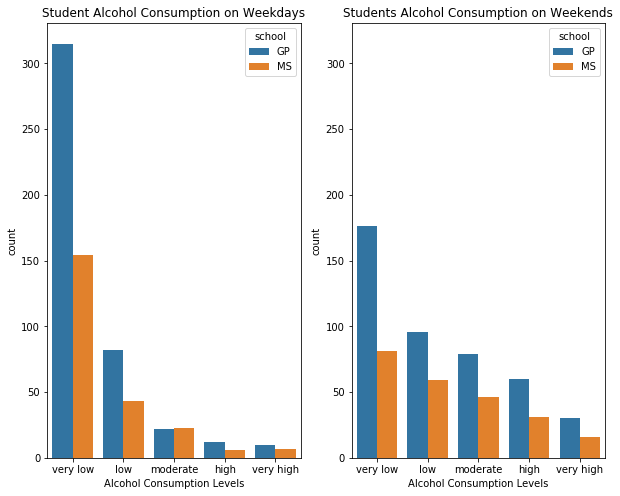

In [14]:
plt.figure(figsize=(10,8))

plt.subplot(1, 2, 1)
order = ('very low','low','moderate','high','very high')
ax1 = sns.countplot(data=data,x='Dalc',hue='school',order=order)
ax1.set_xlabel('Alcohol Consumption Levels')
ax1.set_yticks
plt.title('Student Alcohol Consumption on Weekdays')

plt.subplot(1, 2, 2, sharey=ax1)
order = ('very low','low','moderate','high','very high')
ax2 = sns.countplot(data=data,x='Walc',hue='school',order=order)
ax2.set_xlabel('Alcohol Consumption Levels')
plt.title('Students Alcohol Consumption on Weekends')

At a glance, students both schools consume relatively very low levels of alcohol on weekdays. There is a drastic increase of alcohol consumption over weekends at both schools. Since the sample size of each school is not balanced, we will evaluate the consumption level by each sample size ratio in alcohol consumption.

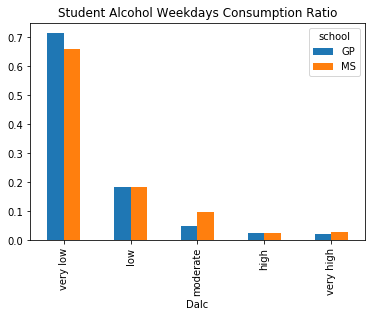

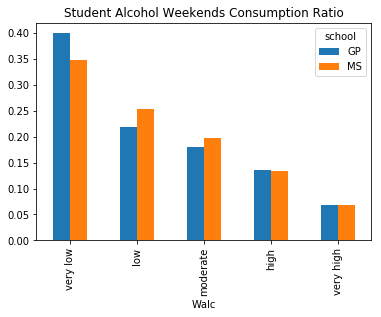

In [15]:
# Plot Student Alcohol Weekly Consumption Ratio by Schools
sch_Dalc = pd.crosstab(index=data['Dalc'],
                      columns=data['school'])
new_index = ['very low','low','moderate','high','very high']
sch_Dalc = sch_Dalc.reindex(new_index)
sch_Dalc = sch_Dalc/sch_Dalc.sum()

sch_Walc = pd.crosstab(index=data['Walc'],
                      columns=data['school'])
sch_Walc = sch_Walc.reindex(new_index)
sch_Walc = sch_Walc/sch_Walc.sum()


sch_Dalc.plot(kind='bar',
              title='Student Alcohol Weekdays Consumption Ratio')
plt.show()

sch_Walc.plot(kind='bar',
             title='Student Alcohol Weekends Consumption Ratio')
plt.show()

When we compare alcohol consumption levels moderate, high, and very high, MS students appear to consume slightly more than GP students on weekdays. The trend remains true for on weekends as well. 

In [16]:

pd.concat([sch_Dalc,sch_Walc], axis=1,
         keys=['Weekdays Alcohol Consumption Ratio',
               'Weekends Alcohol Consumption Ratio'])

Weekdays Alcohol Consumption Ratio            \
school                                    GP        MS   
very low                            0.714286  0.660944   
low                                 0.185941  0.184549   
moderate                            0.049887  0.098712   
high                                0.027211  0.025751   
very high                           0.022676  0.030043   

          Weekends Alcohol Consumption Ratio            
school                                    GP        MS  
very low                            0.399093  0.347639  
low                                 0.217687  0.253219  
moderate                            0.179138  0.197425  
high                                0.136054  0.133047  
very high                           0.068027  0.068670

If we examine rows of increased alcohol consumption (moderate, high, and very high), 9.8% of GP students and 15.3% of MS students consume this amount on weekedays. The precentage of increased consumption level both raise during weekends with 38.3% of GP students and 39.8% of MS students. Overall, we can conclude that MS students consume more alcohol than GP students on a weekly basis. 

## Exploring ages 

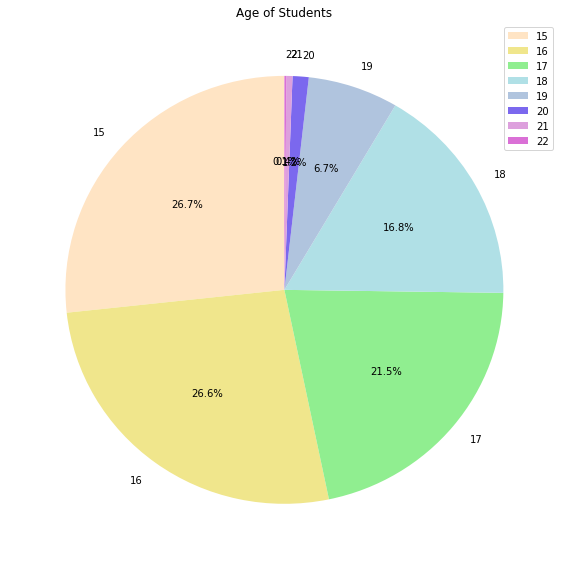

In [17]:
# Plot students age

ages = data['age'].value_counts()
ages.index = ['15','16','17','18','19','20','21','22']
labels = (np.array(ages.index))
sizes = (np.array((ages/ages.sum())*100))
colors = ['bisque','khaki','lightgreen','powderblue',
         'lightsteelblue','mediumslateblue','plum',
         'orchid']

plt.figure(figsize=(8,8))

plt.pie(sizes,labels=labels, colors=colors,autopct='%1.1f%%', 
        startangle=90)
plt.title("Age of Students")
plt.legend(labels)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

##### Age of Students
__Age 15__: 26.7%<br>
__Age 16__: 26.6%<br>
__Age 17__: 21.5%<br>
__Age 18__: 16.8%<br>
__Age 19__: 6.7%<br>
__Age 20__: 1.1%<br>
__Age 21__: 0.4%<br>
__Age 22__: 0.1%<br>


Majority of students are within tradtional high school age range, between 15 to 18 years old. Ages 19 and up make up less than 10% of the student population. Let's see if there are any outliers.

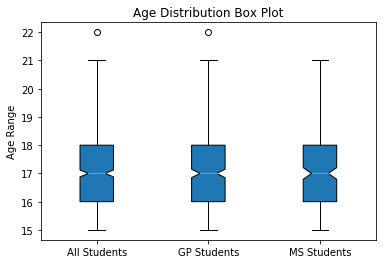

In [18]:
# Plot age distribution 

all= data.age
GP= GP_stud.age
MS=MS_stud.age

box_plot_data=[all,GP,MS]
plt.title('Age Distribution Box Plot')
plt.ylabel('Age Range')
plt.boxplot(box_plot_data,notch='True',patch_artist=True,
            labels=['All Students','GP Students','MS Students'])
plt.show()

According to the box plot, the population age ranges from 15 to 22 years old. The median age for both schools are approximately 17 years old. There does appear to be one outlier, a 22 years old student at GP. This would skew the distribution towards the older age range. 

### Which age group has the highest alcohol consumption during weekdays or weekends? <br>

As shown in the tables below, the sample size of ages 19 and older are rather sparse. We will group ages together in an attempt to better balance the sample size of each test group.


In [19]:
# Create age groups
age15=data[(data.age==15)]
age16=data[(data.age==16)]
age17=data[(data.age==17)]
age18=data[(data.age==18)]
age19=data[(data.age==19)]
age20=data[(data.age==20)]
age21=data[(data.age==21)]
age22=data[(data.age==22)]

In [20]:
# Age Group Weekday 

all=data.Dalc.value_counts()
a15=age15.Dalc.value_counts()
a16=age16.Dalc.value_counts()
a17=age17.Dalc.value_counts()
a18=age18.Dalc.value_counts()
a19=age19.Dalc.value_counts()
a20=age20.Dalc.value_counts()
a21=age21.Dalc.value_counts()
a22=age22.Dalc.value_counts()

age_Dalc = pd.concat([a15,a16,a17,a18,a19,a20,a21,a22,all], 
                     axis=1,sort=True,
         keys=["Age 15","Age 16","Age 17",
                "Age 18", "Age 19", "Age 20", 
               "Age 21","Age 22","All Students"])
new_index = ['very low','low','moderate','high','very high']
age_Dalc = age_Dalc.reindex(new_index)



In [21]:
# Age Group Weekend 
all=data.Walc.value_counts()
a15=age15.Walc.value_counts()
a16=age16.Walc.value_counts()
a17=age17.Walc.value_counts()
a18=age18.Walc.value_counts()
a19=age19.Walc.value_counts()
a20=age20.Walc.value_counts()
a21=age21.Walc.value_counts()
a22=age22.Walc.value_counts()

age_Walc = pd.concat([a15,a16,a17,a18,a19,a20,a21,a22,all], axis=1,sort=True, 
         keys=["Age 15","Age 16","Age 17",
                "Age 18", "Age 19", "Age 20", 
               "Age 21","Age 22","All Students"])
new_index = ['very low','low','moderate','high','very high']
age_Walc = age_Walc.reindex(new_index)

In [22]:
age_tacl = pd.concat([age_Dalc,age_Walc], axis=1,
         keys=['Weekdays Alcohol Consumption by Age',
               'Weekends Alcohol Consumption by Age'])
age_tacl

Weekdays Alcohol Consumption by Age                              \
                                       Age 15 Age 16 Age 17 Age 18 Age 19   
very low                                   82    131    120    100     30   
low                                        22     34     36     26      5   
moderate                                    7      8     15      8      6   
high                                        1      3      3      6      4   
very high                                   1      3      6      5      0   

                                             \
          Age 20 Age 21 Age 22 All Students   
very low       5      1      0          469   
low            2      0      0          125   
moderate       0      1      0           45   
high           1      0      0           18   
very high      0      1      1           17   

          Weekends Alcohol Consumption by Age                              \
                                       Age 15 Age 16 Age 17 Age 18 Age 19   
very low                                   56     72     54     51     20   
low                                        20     43     48     34      8   
moderate                                   20     26     40     25     12   
high                                       12     26     22     24      5   
very high                                   5     12     16     11      0   

                                             
          Age 20 Age 21 Age 22 All Students  
very low       3      1      0          257  
low            1      1      0          155  
moderate       1      1      0          125  
high           2      0      0           91  
very high      1      0      1           46

#### We will combine age groups to create 3 new groups and compare the consumption level 
New groups consists of the following:<br>
__mid teens__: ages 15 and 16<br>
__late teens__: ages 17 and 18<br>
__adult__: ages 19 to 22 

In [23]:
# Create new age groups

mid_teens = data[((data.age > 14) & (data.age < 17))]
late_teens = data[((data.age > 16) & (data.age < 19))]
adult = data[((data.age > 18) & (data.age < 23))]

In [24]:
# New age groups alcohol consumption on weekdays ratio

mt_Dalc = pd.crosstab(index=mid_teens['Dalc'],
                      columns='count')
mt_Dalc = mt_Dalc.reindex(new_index)
mt_Dalc = mt_Dalc/mt_Dalc.sum()

lt_Dalc = pd.crosstab(index=late_teens['Dalc'],
                      columns='count')
lt_Dalc = lt_Dalc.reindex(new_index)
lt_Dalc = lt_Dalc/lt_Dalc.sum()
ad_Dalc = pd.crosstab(index=adult['Dalc'],
                      columns='count')
ad_Dalc = ad_Dalc.reindex(new_index)
ad_Dalc = ad_Dalc/ad_Dalc.sum()


In [25]:
# New age groups alcohol consumption on weekends ratio

mt_Walc = pd.crosstab(index=mid_teens['Walc'],
                      columns='count')
mt_Walc = mt_Walc.reindex(new_index)
mt_Walc = mt_Walc/mt_Walc.sum()

lt_Walc = pd.crosstab(index=late_teens['Walc'],
                      columns='count')
lt_Walc = lt_Walc.reindex(new_index)
lt_Walc = lt_Walc/lt_Walc.sum()
ad_Walc = pd.crosstab(index=adult['Walc'],
                      columns='count')
ad_Walc = ad_Walc.reindex(new_index)
ad_Walc = ad_Walc/ad_Walc.sum()



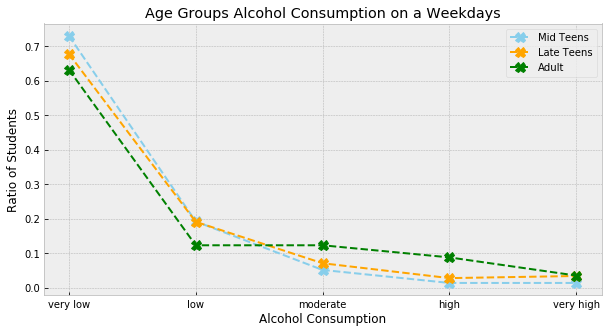

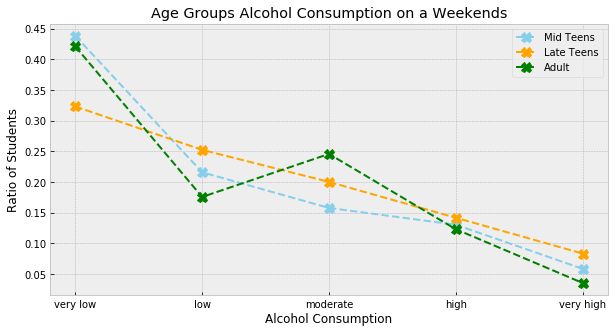

In [26]:

plt.style.use("bmh")
plt.figure(figsize=(10,5))
plt.plot(mt_Dalc,color="skyblue",linestyle="--",marker="X", 
         markersize=10,label="Mid Teens")
plt.plot(lt_Dalc,color="orange",linestyle="--",marker="X", 
         markersize=10,label="Late Teens")
plt.plot(ad_Dalc,color="green",linestyle="--",marker="X", 
         markersize=10,label="Adult")
plt.title("Age Groups Alcohol Consumption on a Weekdays")
plt.xlabel("Alcohol Consumption")
plt.ylabel("Ratio of Students")
plt.legend()
plt.show()

plt.style.use("bmh")
plt.figure(figsize=(10,5))
plt.plot(mt_Walc,color="skyblue",linestyle="--",marker="X", 
         markersize=10,label="Mid Teens")
plt.plot(lt_Walc,color="orange",linestyle="--",marker="X", 
         markersize=10,label="Late Teens")
plt.plot(ad_Walc,color="green",linestyle="--",marker="X", 
         markersize=10,label="Adult")
plt.title("Age Groups Alcohol Consumption on a Weekends")
plt.xlabel("Alcohol Consumption")
plt.ylabel("Ratio of Students")
plt.legend()
plt.show()

On weekdays, mid and late teens drinking patterns are almost parallel to each other. Most of students in their mid and late teens are relatively light drinkers. The adult age group also has similar trends until we reach the moderate to very high alcohol consumption level. Whereas mid and late teens continue to experience a dip from moderate to very high levels, the adult group is more stagnant since students in this group consume higher amounts of alcohol than other groups.<br>

In contrast, there is a change in drinking trends from weekdays to weekends. The mid teens and adult group experience fluctuation from very low to very high alcohol consumption. Meanwhile the late teens group is a linear decline. According to the weekend graph, it’s a bit difficult to determine whether late teens or adult age group consume more alcohol. Next, we will consult an alcohol consumption crosstab table. 

In [27]:
# New age groups alcohol consumption on weekdays ratio

pd.concat([mt_Dalc,lt_Dalc,ad_Dalc], axis=1,
         keys=['Mid Teens Alcohol Consumption Weekdays',
               'Late Teens Alcohol Consumption Weekdays',
              'Adult Alcohol Consumption Weekdays'])

Mid Teens Alcohol Consumption Weekdays  \
col_0                                      count   
Dalc                                               
very low                                0.729452   
low                                     0.191781   
moderate                                0.051370   
high                                    0.013699   
very high                               0.013699   

          Late Teens Alcohol Consumption Weekdays  \
col_0                                       count   
Dalc                                                
very low                                 0.676923   
low                                      0.190769   
moderate                                 0.070769   
high                                     0.027692   
very high                                0.033846   

          Adult Alcohol Consumption Weekdays  
col_0                                  count  
Dalc                                          
very low                            0.631579  
low                                 0.122807  
moderate                            0.122807  
high                                0.087719  
very high                           0.035088

In [28]:
# New age groups alcohol consumption on weekdays ratio

pd.concat([mt_Walc,lt_Walc,ad_Walc], axis=1,
         keys=['Mid Teens Alcohol Consumption Weekends',
               'Late Teens Alcohol Consumption Weekends',
              'Adult Alcohol Consumption Weekends'])

Mid Teens Alcohol Consumption Weekends  \
col_0                                      count   
Walc                                               
very low                                0.438356   
low                                     0.215753   
moderate                                0.157534   
high                                    0.130137   
very high                               0.058219   

          Late Teens Alcohol Consumption Weekends  \
col_0                                       count   
Walc                                                
very low                                 0.323077   
low                                      0.252308   
moderate                                 0.200000   
high                                     0.141538   
very high                                0.083077   

          Adult Alcohol Consumption Weekends  
col_0                                  count  
Walc                                          
very low                            0.421053  
low                                 0.175439  
moderate                            0.245614  
high                                0.122807  
very high                           0.035088

If we reference the weekend ratio table, 42.4% of late teens experience increase alcohol consumption while only 40.2% of students in the adult group increase their consumption level on weekends. We can conclude that the adult age group consumes the most alcohol during weekdays while late teens drink slightly more than adults on weekends. 

## Exploring gender

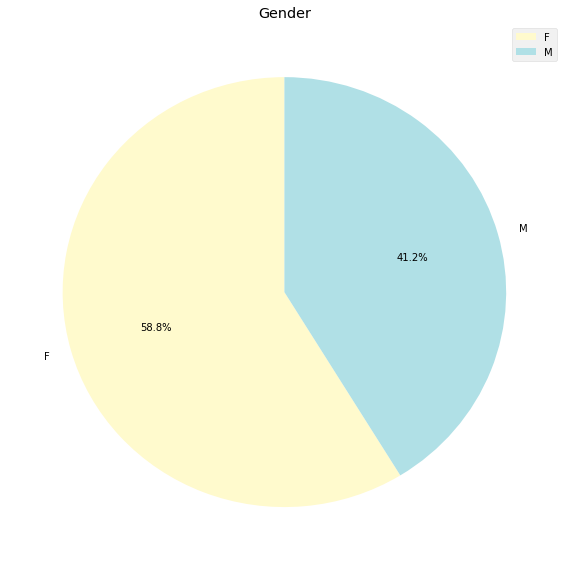

In [29]:
# Plot students gender

sex = data['sex'].value_counts()
sex.index = ['F','M']
labels = (np.array(sex.index))
sizes = (np.array((sex/sex.sum())*100))
colors = ['lemonchiffon','powderblue']

plt.figure(figsize=(8,8))

plt.pie(sizes,labels=labels, colors=colors,autopct='%1.1f%%', 
        startangle=90)
plt.title("Gender")
plt.legend(labels)

ax1.axis('equal')  
plt.tight_layout()
plt.show()

The dataset consists of 58.8% female students and 41.2% male students.

### Which gender consumes more alcohol weekly?

In [30]:
# Create geneders

female = data[data.sex=="F"]
male = data[data.sex=="M"]


In [31]:
# Gender alcohol consumption on weekdays ratio

f_Dalc = pd.crosstab(index=female['Dalc'],
                      columns='count')
f_Dalc = f_Dalc.reindex(new_index)
f_Dalc = f_Dalc/f_Dalc.sum()

m_Dalc = pd.crosstab(index=male['Dalc'],
                      columns='count')
m_Dalc = m_Dalc.reindex(new_index)
m_Dalc = m_Dalc/m_Dalc.sum()


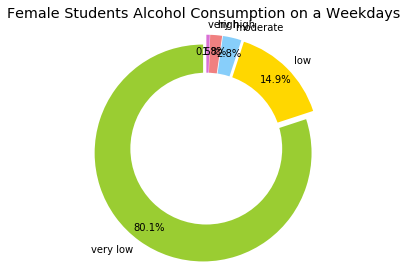

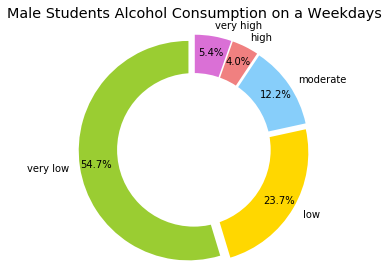

In [32]:
# Female Consumption during Weekdays
female= f_Dalc

colors='yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'orchid'
labels=['very low','low','moderate','high','very high']

fig1, ax1 = plt.subplots()

#explsion
explode = (0.05,0.05,0.05,0.05,0.05)

ax1.pie(female, colors = colors, labels=labels,autopct='%1.1f%%', 
        startangle=90, pctdistance=0.85, explode=explode)
plt.title("Female Students Alcohol Consumption on a Weekdays")

# Draw a circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal') 
plt.tight_layout()
plt.show()

# Male Consumption during Weekdays
male= m_Dalc

colors='yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'orchid'

fig1, ax1 = plt.subplots()

#explsion
explode = (0.05,0.05,0.05,0.05,0.05)

ax1.pie(male, colors = colors, labels=labels, autopct='%1.1f%%', 
        startangle=90, pctdistance=0.85, explode=explode)
plt.title("Male Students Alcohol Consumption on a Weekdays")

# Draw a circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal') 
plt.tight_layout()
plt.show()

Base on the pie charts above, female students generally consume lower amounts of alcohol than male students during weekdays. While 90% of females identified themselves as light drinkers, approximately 65% of male students have a low intake of alcohol. Let's see if this changes over the weekend.

In [33]:
# Gender alcohol consumption on weekends ratio

female = data[data.sex=="F"]
male = data[data.sex=="M"]

f_Walc = pd.crosstab(index=female['Walc'],
                      columns='count')
f_Walc = f_Walc.reindex(new_index)
f_Walc = f_Walc/f_Walc.sum()

m_Walc = pd.crosstab(index=male['Walc'],
                      columns='count')
m_Walc = m_Walc.reindex(new_index)
m_Walc = m_Walc/m_Walc.sum()


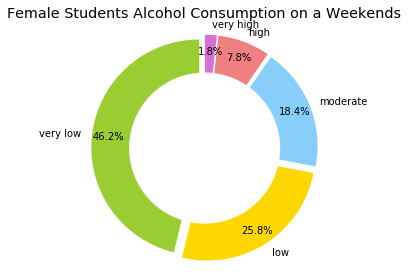

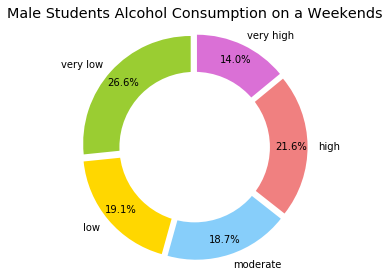

In [34]:
# Female Consumption during Weekends
female= f_Walc

colors='yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'orchid'
labels=['very low','low','moderate','high','very high']

fig1, ax1 = plt.subplots()

#explsion
explode = (0.05,0.05,0.05,0.05,0.05)

ax1.pie(female, colors = colors, labels=labels,autopct='%1.1f%%', 
        startangle=90, pctdistance=0.85, explode=explode)
plt.title("Female Students Alcohol Consumption on a Weekends")

# Draw a circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal') 
plt.tight_layout()
plt.show()

# Male Consumption during Weekends
male= m_Walc

colors='yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'orchid'

fig1, ax1 = plt.subplots()

#explsion
explode = (0.05,0.05,0.05,0.05,0.05)

ax1.pie(male, colors = colors, labels=labels, autopct='%1.1f%%', 
        startangle=90, pctdistance=0.85, explode=explode)
plt.title("Male Students Alcohol Consumption on a Weekends")

# Draw a circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal') 
plt.tight_layout()
plt.show()

There is a distinctive difference between female and male students alcohol consumption during weekends. Only 28% of female students consume moderate to very high levels of alcohol. In contrast, more than half of male students claim to consume moderate to very heavy levels of alcohol. 

## Exploring address

Text(0.5,1,'Student Address')

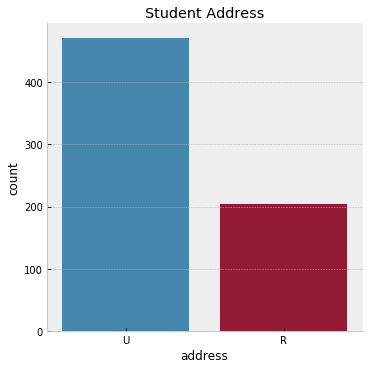

In [35]:
sns.catplot(x="address", kind='count', data=data)
plt.title("Student Address")

Majority of students reside in urban areas while only a third of the population are in rural settings.

### Do students in ubran areas consume more alcohol than those who live in rural areas?

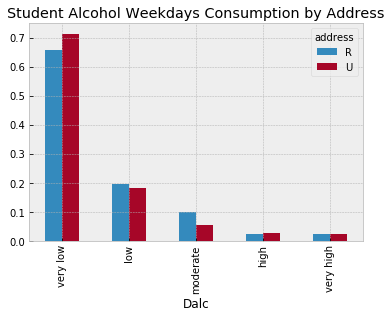

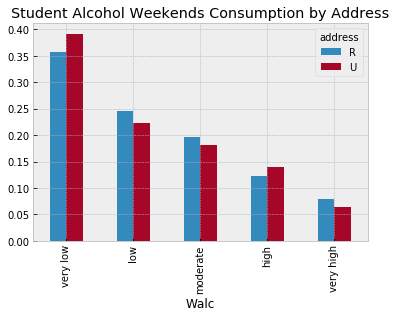

In [36]:
# Plot Student Alcohol Weekly Consumption Ratio by Schools

add_Dalc = pd.crosstab(index=data['Dalc'],
                      columns=data['address'])
new_index = ['very low','low','moderate','high','very high']
add_Dalc = add_Dalc.reindex(new_index)
add_Dalc = add_Dalc/add_Dalc.sum()

add_Walc = pd.crosstab(index=data['Walc'],
                      columns=data['address'])
add_Walc = add_Walc.reindex(new_index)
add_Walc = add_Walc/add_Walc.sum()


add_Dalc.plot(kind='bar',
              title='Student Alcohol Weekdays Consumption by Address')
plt.show()

add_Walc.plot(kind='bar',
             title='Student Alcohol Weekends Consumption by Address')
plt.show()

In the bar graphs above, students in both settings generally consume low levels of alcohol consumption throughout the entire week. During weekedays, we can assume that students in rural areas drink more than students in urbans settings. However, it is not clear which group consumes more alcohol during weekends so we will follow with a crosstab table. 

In [37]:
# Alcohol consumption on a weekly basis ratio by address

pd.concat([add_Dalc,add_Walc], axis=1,
         keys=['Students Alcohol Consumption on Weekdays',
               'Students Alcohol Consumption on Weekends'])

Students Alcohol Consumption on Weekdays            \
address                                          R         U   
very low                                  0.656863  0.712766   
low                                       0.196078  0.180851   
moderate                                  0.098039  0.053191   
high                                      0.024510  0.027660   
very high                                 0.024510  0.025532   

          Students Alcohol Consumption on Weekends            
address                                          R         U  
very low                                  0.357843  0.391489  
low                                       0.245098  0.223404  
moderate                                  0.196078  0.180851  
high                                      0.122549  0.140426  
very high                                 0.078431  0.063830

During weekdays, 14.6% of students in rural areas and 10.5% from urban areas consume moderate to very high levels of alcohol. This consumption trend remains the same on weekends with a minor difference. The number of student in rural areas that consume moderate to very high levels of alcohol doubles to 39.6% on weekends. Students in urban settings are only slightly behind with 38.3% of students claiming to increase their alcohol intake. 


## Conclusion 

__Base on the analysis, we can conclude the following__:

Generally, students tend to consume higher levels of alcohol during weekends. There also appears to be a positive correlation between increased alcohol consumption and age groups. Students in older age groups consume more alcohol than younger students. Male students also consume more and higher levels of alcohol than female students throughout the week. The data also shows that on average, students residing in urban settings consume less alcohol than students in rural areas. 

__Limitations__

In terms of analyzing the data, most of the variables I selected, particularly weekday and weekend alcohol consumption, were categorical/nominal. This presented a challenge when visualizing the data since I was limited to mainly tables, bar charts, and pie charts. Combining weekday and weekend consumption to reduce the repetition of graphs was not possible since the data was not numeric. 

Another limitation occurred during the creation of sample data groups.  For example, in determining which age group consumed the most alcohol on a weekly basis, some of the sample groups were significantly small. Age group 15 to 18 had at least 100 students in each group, while ages 20 and up had less than 10 data points. I attempted to increase the sample sizes to more accurately represent the student population by reducing the age groups from 7 to 3. 

__Recommendations for further analysis__

With the current information given, I would like to explore how different attributes interact with each other to better understand the affects of alcohol consumption on students and their performance in school. For example, I would like to see if increased alcohol consumption correlates to low performance in school. If this is true, do variables, such as free time or romantic relationships, influence students to drink?  This information would be meaningful for parents and educators in creating and promoting an environment for student success. 